# SHAP (SHapley Additive exPlanations)

**SHAP**是一种解释任何机器学习输出的博弈论方法。它利用博弈论中的经典Shapley values及其相关延伸，将最优学分分配（optimal credit allocation）与局部解释（local explanations）联系起来。

## 安装

SHAP可以从[PyPI](https://pypi.org/project/shap/)或者[conda-forge](https://anaconda.org/conda-forge/shap)中安装


pip install shap<br/> 
or <br/>
conda install -c conda-forge shap

若之前未安装XGBoost，可用以下代码在本项目hydrus环境中打开jupyter notebook终端进行安装

conda install -c  anaconda py-xgboost 

## 利用SHAP解释XGBoost模型

[XGBOOST](https://zhuanlan.zhihu.com/p/75217528)相对于线性模型在进行预测时往往有更好的精度，但是同时也失去了线性模型的可解释性。所以Xgboost通常被认为是黑箱模型。<br/>2017年，Lundberg和Lee的论文提出了SHAP值这一广泛适用的方法用来解释各种模型（分类以及回归），其中最大的受益者莫过于之前难以被理解的黑箱模型，如xgboost和神经网络模型。



### Feature importance

在SHAP被广泛使用之前，我们通常用feature importance或者partial dependence plot来解释xgboost。<br /> **feature importance是用来衡量数据集中每个特征的重要性。**<br>简单来说，**每个特征对于提升整个模型的预测能力的贡献程度就是特征的重要性。**<br />Feature importance可以直观地反映出特征的重要性，看出哪些特征对最终的模型影响较大。但是无法判断特征与最终预测结果的关系是如何的。

### 下面这个例子，我们用2018年足球球员身价数据（请在SofaSofa数据竞赛页面进行数据下载，下载解压后只需要train.csv这个文件）来具体阐述。

[20:21:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


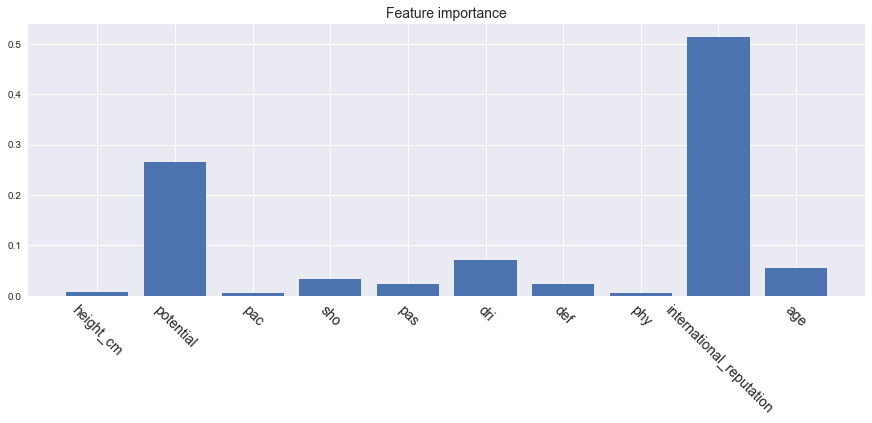

In [3]:
#加载模块
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('seaborn')
# 读取数据，目标变量y是球员的身价（万欧元）
data = pd.read_csv("F:/科研类/数据资料/data/train.csv")
# 获得当时球员年龄
today = pd.to_datetime('2021-04-01')
data['birth_date'] = pd.to_datetime(data['birth_date'])
data['age'] = np.round((today - data['birth_date']).apply(lambda x: x.days) / 365., 1)
# 选择特征，这里只是举例，未必是最佳组合
# 特征依次为身高（厘米）、潜力、速度、射门、传球、带球、防守、体格、国际知名度、年龄

cols = ['height_cm', 'potential', 'pac', 'sho', 'pas', 'dri', 'def', 'phy', 'international_reputation', 'age']
# 训练xgboost回归模型
model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=150)
model.fit(data[cols], data['y'].values)
# 获取feature importance
plt.figure(figsize=(15, 5))#宽度和高度
plt.bar(range(len(cols)), model.feature_importances_)
plt.xticks(range(len(cols)), cols, rotation=-45, fontsize=14)#x标签旋转-45°
plt.title('Feature importance', fontsize=14)
plt.show()

上图中，我们可以看出国际知名度、潜力和年龄是影响球员身价最重要的三个因素。但是这些因素和身价是正相关、负相关还是其他更复杂的相关性，我们无法从上图得知。我们也无法解读每个特征对每个个体的预测值的影响。

### SHAP value

SHAP的名称来源于**SH**apley **A**dditive ex**P**lanation。<br />
Shapley value起源于合作博弈论。比如说甲乙丙丁四个工人一起打工，甲和乙完成了价值100元的工件，甲、乙、丙完成了价值120元的工件，乙、丙、丁完成了价值150元的工件，甲、丁完成了价值90元的工件，那么该如何公平、合理地分配这四个人的工钱呢？Shapley提出了一个合理的计算方法(有兴趣可以查看[原论文](https://apps.dtic.mil/dtic/tr/fulltext/u2/604084.pdf ))，我们称每个参与者分配到的数额为Shapley value。<br />
SHAP是由Shapley value启发的可加性解释模型。对于每个预测样本，模型都产生一个预测值，SHAP value就是该样本中每个特征所分配到的数值。 <br />SHAP是由Shapley value启发的可加性解释模型。对于每个预测样本，模型都产生一个预测值，SHAP value就是该样本中每个特征所分配到的数值。<br /> 假设第i个样本为xi，第i个样本的第j个特征为xi,j，模型对第i个样本的预测值为yi，整个模型的基线（通常是所有样本的目标变量的均值）为ybase，那么SHAP value服从以下等式。


yi=ybase+f(xi,1)+f(xi,2)+⋯+f(xi,k)

其中f(xi,1)为xi,j的SHAP值。直观上看，f(xi,1)就是第i个样本中第1个特征对最终预测值yi的贡献值，当f(xi,1)>0，说明该特征提升了预测值，也正向作用；反之，说明该特征使得预测值降低，有反作用。<br />

很明显可以看出，与上一节中feature importance相比，SHAP value最大的优势是SHAP能对于反映出每一个样本中的特征的影响力，而且还表现出影响的正负性。


### SHAP的Python实现

上面已经介绍过SHAP的安装。<br />
下面我们针对第1节中训练出的模型model，计算其SHAP值。<br />
引用package并且获得解释器explainer。

In [4]:
import shap
# model是在第1节中训练的模型
explainer = shap.TreeExplainer(model)

获取训练集data各个样本各个特征的SHAP值。<br />

因为data中有10441个样本以及10个特征，我们得到的shap_values的维度是10441×1010441×10。

In [5]:
shap_values = explainer.shap_values(data[cols])
print(shap_values.shape)


(10441, 10)


我们也可以获得在第2节中提到的模型的基线ybase。<br />

通过对比发现，我们可以确认基线值就是训练集的目标变量的拟合值的均值。在这里例子中，目标变量是球员的身价（万欧元），也就是球员的平均身价为229万欧元。

In [6]:
y_base = explainer.expected_value
print(y_base)

data['pred'] = model.predict(data[cols])
print(data['pred'])
print(data['pred'].mean())

229.16527
0          50.478256
1          25.776320
2          11.592649
3        1553.479126
4         102.300919
            ...     
10436      52.070610
10437      29.213802
10438     853.221375
10439     660.081177
10440     123.512627
Name: pred, Length: 10441, dtype: float32
229.16533


### 单个样本的SHAP值

我们可以随机检查其中一位球员身价的预测值以及其特征对预测值的影响。<br />
下面的数据框中第一列是特征名称，第二列是特征的数值，第三列是各个特征在该样本中对应的SHAP值。

In [6]:
# 比如我们挑选数据集中的第30位
j = 30
player_explainer = pd.DataFrame()
player_explainer['feature'] = cols
player_explainer['feature_value'] = data[cols].iloc[j].values
player_explainer['shap_value'] = shap_values[j]
player_explainer

,feature,feature_value,shap_value
0,height_cm,185.0,1.635100
1,potential,86.0,1103.072144
2,pac,69.0,-2.152314
3,sho,55.0,-32.339676
4,pas,68.0,-12.522460
5,dri,71.0,2.006886
6,def,76.0,110.723640
7,phy,84.0,18.646975
8,international_reputation,2.0,112.543602
9,age,23.9,-204.468323


我们知道一个样本中各特征SHAP值的和加上基线值应该等于该样本的预测值。<br />
我们可以做如下的验证。

In [7]:
print('y_base + sum_of_shap_values: %.2f'%(y_base + player_explainer['shap_value'].sum()))
print('y_pred: %.2f'%(data['pred'].iloc[j]))

y_base + sum_of_shap_values: 1326.31
y_pred: 1326.31


shap还提供极其强大的数据可视化功能。下图是对上面数据框的可视化。<br />
蓝色表示该特征的贡献是负数，红色则表示该特征的贡献是正数。最长的红色条是潜力值，球员的潜力值很高，而他的身价也因此增加了1092万；最长的蓝色条是年龄，这个球员年龄较小才20岁出头，尚未到职业巅峰，未来也有诸多不确定性，身价也因此降低了180万元。

In [8]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[j], data[cols].iloc[j])

### 对特征的总体分析

除了能对单个样本的SHAP值进行可视化之外，还能对特征进行整体的可视化。

下图中每一行代表一个特征，横坐标为SHAP值。一个点代表一个样本，颜色越红说明特征本身数值越大，颜色越蓝说明特征本身数值越小。

我们可以直观地看出潜力potential是一个很重要的特征，而且基本上是与身价成正相关的。年龄age也会明显影响身价，蓝色点主要集中在SHAP小于0的区域，可见年纪小会降低身价估值，另一方面如果年纪很大，也会降低估值，甚至降低得更明显，因为age这一行最左端的点基本上都是红色的。

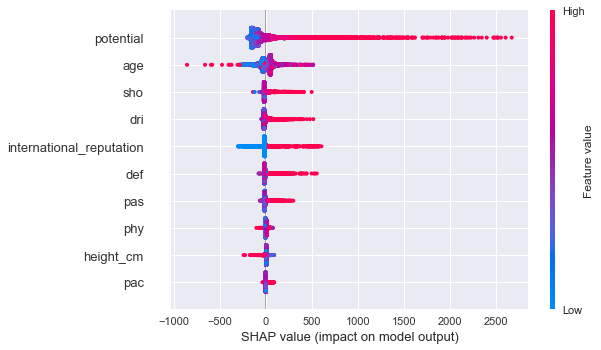

In [11]:
shap.summary_plot(shap_values, data[cols])

我们也可以把一个特征对目标变量影响程度的绝对值的均值作为这个特征的重要性。<br />

因为SHAP和feature_importance的计算方法不同，所以我们这里也得到了与第1节不同的重要性排序。

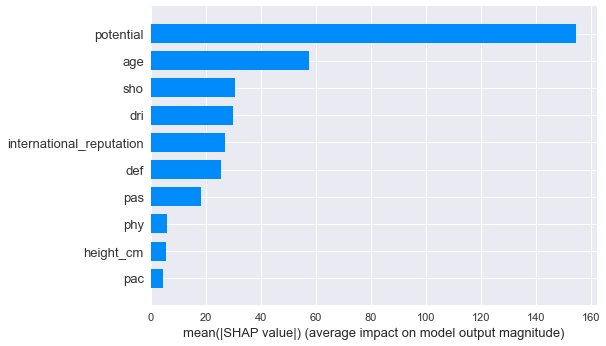

In [13]:
shap.summary_plot(shap_values, data[cols], plot_type="bar")

### 部分依赖图Partial Dependence Plot

SHAP也提供了部分依赖图的功能，与传统的部分依赖图不同的是，这里纵坐标不是目标变量y的数值而是SHAP值。<br />

比如下图中，年纪大概呈现出金字塔分布，也就是24到31岁这个年纪对球员的身价是拉抬作用，小于24以及大于31岁的球员身价则会被年纪所累。

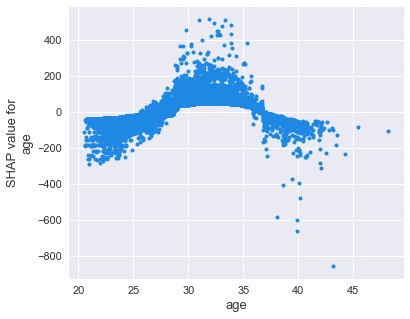

In [14]:
shap.dependence_plot('age', shap_values, data[cols], interaction_index=None, show=False)

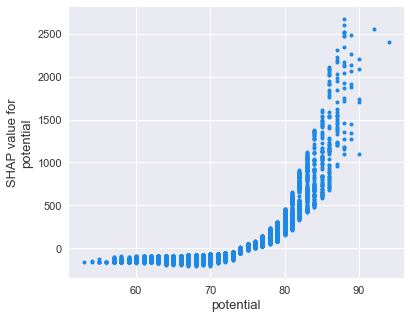

In [6]:
shap.dependence_plot('potential', shap_values, data[cols], interaction_index=None, show=False)

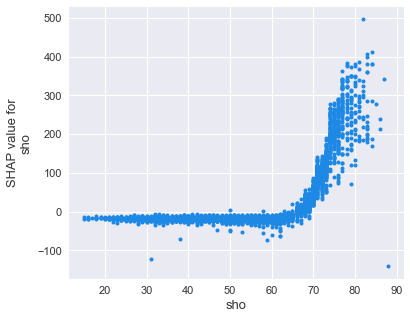

In [8]:
shap.dependence_plot('sho', shap_values, data[cols], interaction_index=None, show=False)

### 对多个变量的交互进行分析

我们也可以多个变量的交互作用进行分析。一种方式是采用summary_plot描绘出散点图，如下：

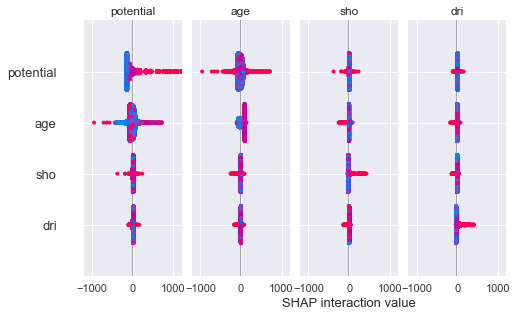

In [15]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(data[cols])
shap.summary_plot(shap_interaction_values, data[cols], max_display=4)

我们也可以用dependence_plot描绘两个变量交互下变量对目标值的影响

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


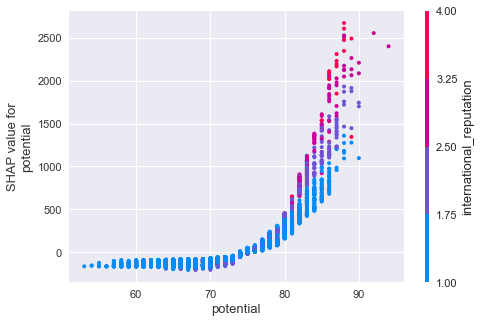

In [16]:
shap.dependence_plot('potential', shap_values, data[cols], interaction_index='international_reputation', show=False)

**international_reputation数值越大，越提升potentional的shap值。**

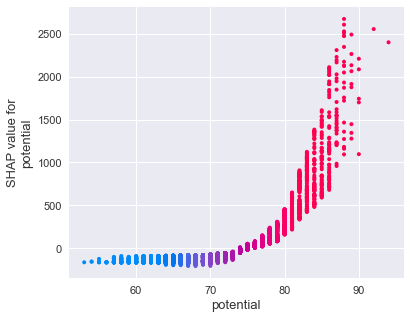

In [7]:
shap.dependence_plot('potential', shap_values, data[cols], interaction_index='potential', show=False)

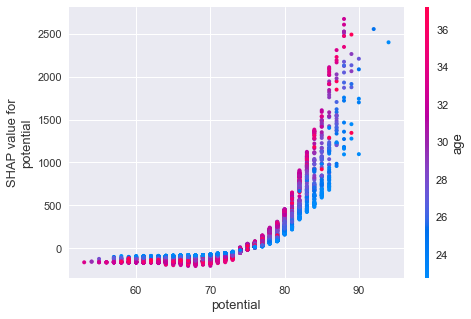

In [9]:
shap.dependence_plot('potential', shap_values, data[cols], interaction_index='age', show=False)

**age的数值小时，会降低potention的shap值，当age增大时，会增加potention的shap值，当然age并不是越大也好。**

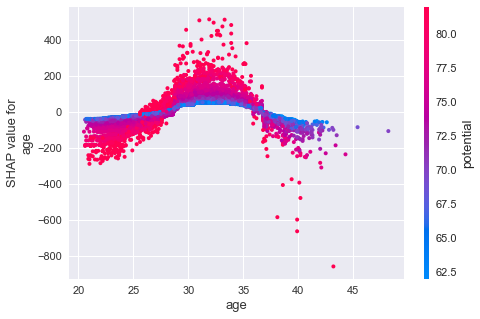

In [10]:
shap.dependence_plot('age', shap_values, data[cols], interaction_index='potential', show=False)

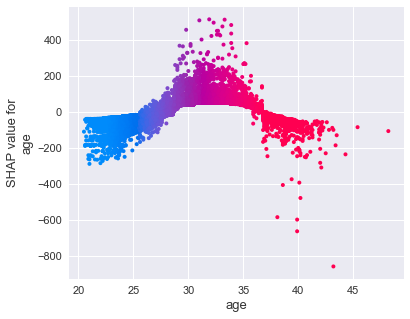

In [11]:
shap.dependence_plot('age', shap_values, data[cols], interaction_index='age', show=False)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


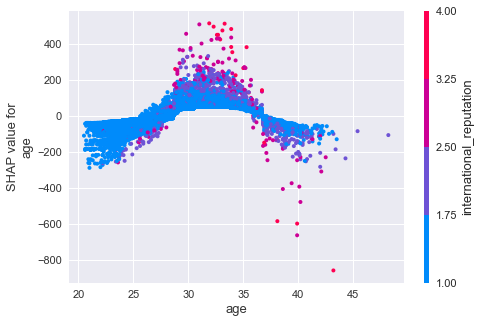

In [12]:
shap.dependence_plot('age', shap_values, data[cols], interaction_index='international_reputation', show=False)

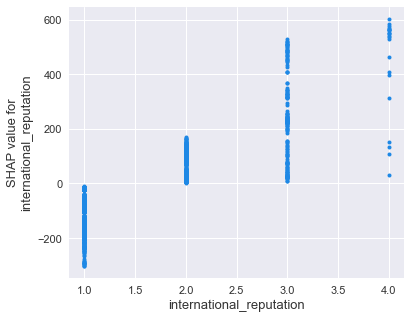

In [14]:
shap.dependence_plot("international_reputation", shap_values, data[cols], interaction_index=None, show=False)

## Tree ensemble example(XGBoost/LightGBM/CatBoost/scikit-learn/pyspark models)

 虽然SHAP可以解释任何机器学习模型的输出，但已经开发了一种高速精确的Tree ensemble methods(数集成方法)算法（参见[Nature MI paper](https://www.nature.com/articles/s42256-019-0138-9.epdf?shared_access_token=RCYPTVkiECUmc0CccSMgXtRgN0jAjWel9jnR3ZoTv0O81kV8DqPb2VXSseRmof0Pl8YSOZy4FHz5vMc3xsxcX6uT10EzEoWo7B-nZQAHJJvBYhQJTT1LnJmpsa48nlgUWrMkThFrEIvZstjQ7Xdc5g%3D%3D)）。XGBoost, LightGBM, CatBoost, scikit-learn和pyspark树模型支持快速c++实现

[10:49:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


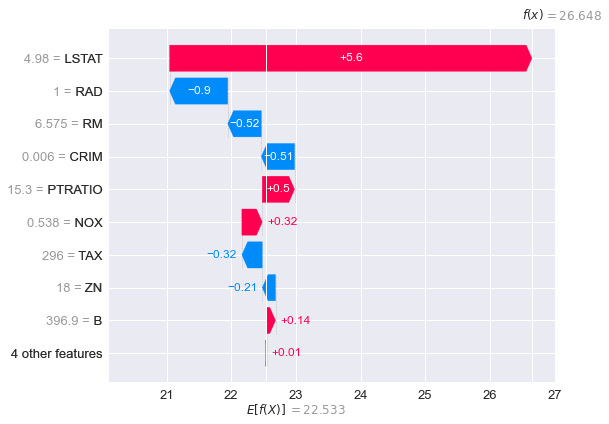

In [10]:
import xgboost
import shap
#train an XGBoost model 
X,y=shap.datasets.boston()
model=xgboost.XGBRegressor().fit(X,y)
#explain the model"s predictions using SHAP
#(same syntax(语法) works for LightGBM,CatBoost, scikit-learn, transformers, Spark, etc.)
explainer=shap.Explainer(model)
shap_values=explainer(X)
#visualize the first prediction"s explanation
shap.plots.waterfall(shap_values[0])


 上面的解释显示了每个特性，它们有助于将基值（我们传递的训练数据集上的平均模型输出）的模型输出推到模型输出。将**预测推高的特征用红色**表示，将**预测推低的特征用蓝色**表示。另一种可视化解释的方式是**force plot**。(可在[Nature BME paper](https://www.nature.com/articles/s41551-018-0304-0.epdf?author_access_token=vSPt7ryUfdSCv4qcyeEuCdRgN0jAjWel9jnR3ZoTv0PdqacSN9qNY_fC0jWkIQUd0L2zaj3bbIQEdrTqCczGWv2brU5rTJPxyss1N4yTIHpnSv5_nBVJoUbvejyvvjrGTb2odwWKT2Bfvl0ExQKhZw%3D%3D)找到相关介绍)


In [11]:
#visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])